# <font color="#4B0082"> Predicting Iris Flower type based on Petal measurements and Sepal measurements

<img src="https://i.gifer.com/OpHc.gif" width = "600"/>

 ### Introduction:   
Our project will focus on ....

 ### Methods & Results
As mentioned in the introduction, the goal of our project is to determine what group of factors has the most influence on the prediction of type the Iris flower between the 3 types of 
Iris variegata, Iris Setosa, and Iris Versicolor. of an individual. Since this is a predictive question, we will be using classification to respond to it.

First, we load the necessary packages into R, including the `“kknn”` package required for our classification process. We also set our seed to `1382` for reproducibility.

In [1]:
# KM - Run cell before starting workspace - loads necessary packages
library(tidyverse)
library(repr)
library(tidymodels)
library(tibble)
options(repr.matrix.max.rows = 6)
install.packages("kknn")

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.4.2     ✔ purrr   1.0.1
✔ tibble  3.2.1     ✔ dplyr   1.1.1
✔ tidyr   1.3.0     ✔ stringr 1.5.0
✔ readr   2.1.3     ✔ forcats 0.5.2
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.2     ✔ rsample      1.1.1
✔ dials        1.1.0     ✔ tune         1.0.1
✔ infer        1.0.4     ✔ workflows    1.1.2
✔ modeldata    1.0.1     ✔ workflowsets 1.0.0
✔ parsnip      1.0.3     ✔ yardstick    1.1.0
✔ recipes      1.0.4     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks read

We read the data set into R, using the `read_csv` function since the data set contained comma separated values. The original dataset also did not have any names describing each column. Thus, we renamed the columns by referring to the website. Then we printed the data set to see what it looks like.

In [2]:
iris_data <- read_csv ("data/iris.data")
iris_data

Rows: 149 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (1): Iris-setosa
dbl (4): 5.1, 3.5, 1.4, 0.2

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


5.1,3.5,1.4,0.2,Iris-setosa
<dbl>,<dbl>,<dbl>,<dbl>,<chr>
4.9,3.0,1.4,0.2,Iris-setosa
4.7,3.2,1.3,0.2,Iris-setosa
4.6,3.1,1.5,0.2,Iris-setosa
⋮,⋮,⋮,⋮,⋮
6.5,3.0,5.2,2.0,Iris-virginica
6.2,3.4,5.4,2.3,Iris-virginica
5.9,3.0,5.1,1.8,Iris-virginica


After importing the dataset from the provided link, we observed that the columns lacked descriptive names, making it challenging to interpret and analyze the data effectively. In response, we took a step in our data wrangling and cleaning process by assigning meaningful names to each column based on the information available on the source website, using the `setNames` function.

Simultaneously, we noted that the rows were originally organized based on the iris types, where all rows corresponding to one type of iris flower were grouped together, followed by rows of the second type, and so on. However, this organization could introduce bias when splitting the data for training and testing purposes.

To address this concern, we decided to randomize the order of the rows. We used the `slice` function to do this. By doing so, we ensure that our subsequent data split into training and testing sets will be representative and unbiased, with a balanced representation of all three types of iris flowers. This comprehensive approach to data preparation, including renaming columns and randomizing rows, sets the foundation for a more reliable and robust analysis in our exploration of the Iris dataset.

Furthermore, we noticed that the 'class' column contained values with the `Iris-` prefix (e.g., `Iris-versicolor`, `Iris-setosa`). To enhance clarity and simplicity in our data, we decided to rename the `class` column by removing the `Iris-` prefix.

We accomplished this using the mutate function from the dplyr package, combined with the gsub function. The gsub function allowed us to globally substitute the 'Iris_' prefix with an empty string, effectively leaving only the type of iris flower in the 'class' column.

Furthermore, since we are predicting the type of iris flower, we mutated the data set with `as_factor` function so that `class` is treated as a factor for our future classifications.

We named the final data set `iris_clean`.

In [3]:
set.seed (1402)
iris_clean <- iris_data |>
    setNames(c("sepal_length", "sepal_width", "petal_length", "petal_width", "class"))|>
    slice(sample(n())) |>
    mutate(class = gsub("Iris-", "", class)) |>
    mutate (class= as_factor (class))
iris_clean

sepal_length,sepal_width,petal_length,petal_width,class
<dbl>,<dbl>,<dbl>,<dbl>,<fct>
5.6,2.5,3.9,1.1,versicolor
5.5,2.4,3.7,1.0,versicolor
5.6,2.8,4.9,2.0,virginica
⋮,⋮,⋮,⋮,⋮
4.8,3.0,1.4,0.3,setosa
6.4,2.8,5.6,2.2,virginica
5.4,3.4,1.5,0.4,setosa


#### Visualization

Following our research of the topic, we decided to compare the `petal_width` vs. `sepal_width` so see whether there is a pattern in that scatterplot based on the type of flower. We also visualized the `petal_length` vs. `sepal_length` for the same purpose.
For better visualization, we adjusted the size and style of the title, labels, and legends using the `theme` function. Furthermore, we created our own color palette since we wanted the colors to have the same theme with the iris flower itself and so that there is a consistent theme throughout our project. we named our palette `iris_colors` and used the `scale_color_manual` to apply them into our scatterplot. Last but not least, we renamed the legends so that they start with an uppercase letter. 

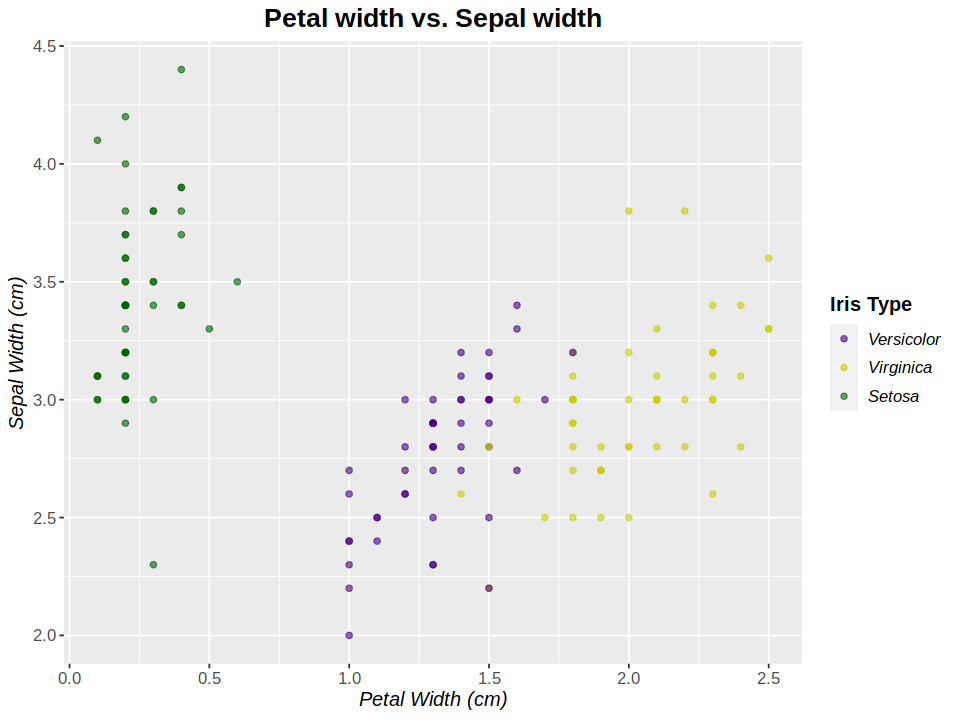

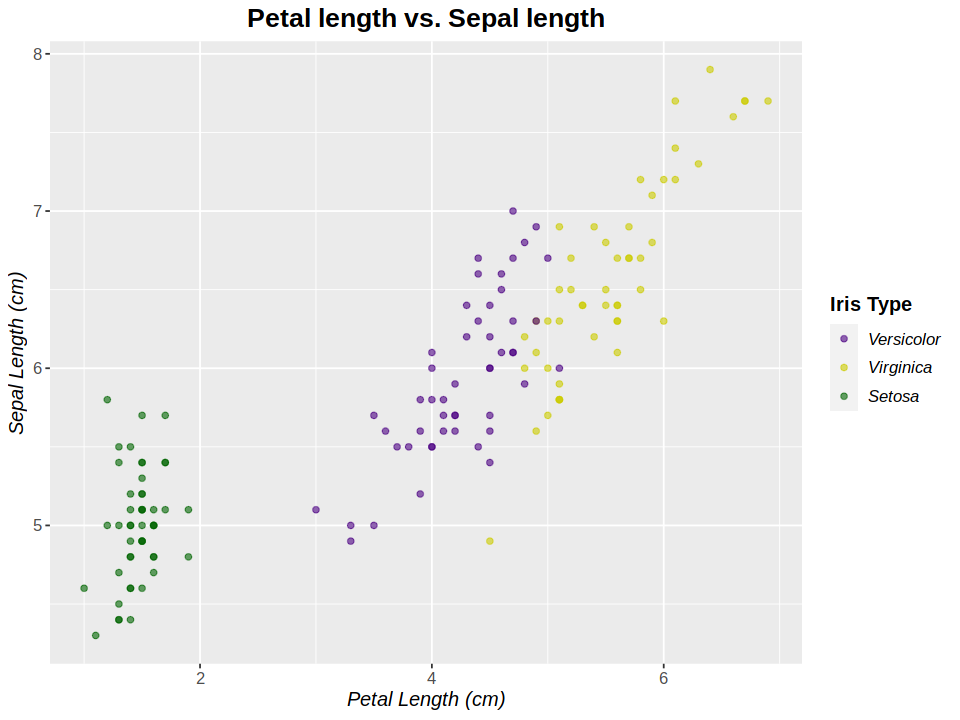

In [33]:
options(repr.plot.width = 8, repr.plot.height = 6)

#Scatterplot visualization of Petal vs. Sepal width:
iris_colors <- c("setosa" = "#006400", "versicolor" = "#4B0082", "virginica" ="#CCCC00" )


petal_vs_sepal_width <- iris_clean |>
ggplot(aes (x= petal_width, y= sepal_width , color = class))+
geom_point (alpha = 0.6)+
labs (x = "Petal Width (cm)", 
       y = "Sepal Width (cm)",
       color = "Iris Type")+
    ggtitle("Petal width vs. Sepal width")+
    scale_color_manual(values = iris_colors,
                   labels = c("Versicolor", "Virginica", "Setosa"))+
    theme(plot.title = element_text(face = "bold", size = 16, hjust = 0.5),
    axis.title = element_text(face = "italic", size = 12),
    axis.text = element_text(size = 10),
    legend.title = element_text(face = "bold", size = 12),
    legend.text = element_text(face = "italic", size = 10))
petal_vs_sepal_width

#Scatterplot visualization of Petal vs. Sepal length:
petal_vs_sepal_length <- iris_clean |>
ggplot(aes (x= petal_length, y= sepal_length , color = class))+
geom_point (alpha = 0.6)+
labs (x = "Petal Length (cm)", 
       y = "Sepal Length (cm)",
       color = "Iris Type")+
ggtitle("Petal length vs. Sepal length")+
scale_color_manual(values = iris_colors,
                   labels = c("Versicolor", "Virginica", "Setosa"))+
    theme(plot.title = element_text(face = "bold", size = 16, hjust = 0.5),
    axis.title = element_text(face = "italic", size = 12),
    axis.text = element_text(size = 10),
    legend.title = element_text(face = "bold", size = 12),
    legend.text = element_text(face = "italic", size = 10))
petal_vs_sepal_length

After conducting a visual exploration of the relationships between petal and sepal measurements in our dataset, we created scatterplots to compare petal_width vs. sepal_width and petal_length vs. sepal_length. These visualizations revealed compelling patterns where points from the same iris type tended to cluster together in different regions of the plots. This suggested a potential relationship between petal and sepal measurements and the type of iris flower.

To leverage this observed pattern, we have decided to design two distinct prediction models. One model will focus on utilizing petal length and width as features, while the other model will use sepal length and width. This segmentation allows us to investigate the contributions of both petal and sepal measurements independently in predicting the iris flower type, providing insights into which set of features plays a more significant role in classification.

To determine the optimal parameter `k` for our `kknn` classification models, we will perform cross-validation. This process helps ensure that our models generalize well to new, unseen data. Once we have identified the best k values, we will train our kknn models on both sets of features and evaluate their accuracies.

By comparing the accuracies of the two models, we aim to quantify the relative importance of sepal measurements versus petal measurements in determining the iris flower type among the three classes: `Virginica`, `Setosa`, and `Versicolor`. This approach allows us to gain a nuanced understanding of the predictive power of each set of measurements and contributes to a more comprehensive analysis of the dataset.

#### Expected Outcomes and Significance:  
We hypothesize the (sepal or petal, we have to chose this based on research) category predictors will have the highest accuracy to be used as a prediction model to find out the type of iris flower. Literature suggests that....

#### Classification:
Starting the classification process, we first divide our data into training and testing sets to train our models on training set and then test for their accuracies on testing set.

In [5]:
set.seed(1402)  # Set your desired seed for reproducibility

# Split data
pre_split_iris <- iris_clean
iris_split <- initial_split(pre_split_iris, prop = 0.7, strata = class)

# Shuffle the split using slice_sample
iris_train <- slice_sample(training(iris_split), prop = 1)
iris_test <- slice_sample(testing(iris_split), prop = 1)

# Display the head of the training and testing set
head(iris_train)
head(iris_test)


sepal_length,sepal_width,petal_length,petal_width,class
<dbl>,<dbl>,<dbl>,<dbl>,<fct>
5.4,3.9,1.3,0.4,setosa
6.4,2.8,5.6,2.1,virginica
6.7,3.1,5.6,2.4,virginica
5.2,4.1,1.5,0.1,setosa
5.4,3.0,4.5,1.5,versicolor
7.7,2.6,6.9,2.3,virginica


sepal_length,sepal_width,petal_length,petal_width,class
<dbl>,<dbl>,<dbl>,<dbl>,<fct>
6.7,3.3,5.7,2.5,virginica
5.6,2.5,3.9,1.1,versicolor
6.9,3.1,5.1,2.3,virginica
5.8,2.7,3.9,1.2,versicolor
6.8,3.0,5.5,2.1,virginica
5.8,2.7,5.1,1.9,virginica


#### Now, We start creating our models, training them, and obtaining their accuracies.
### Petal KNN Classification:
#### Predictors: 
    * Petal Width
    * Petal Length

### 1. First we perform cross-validation to obtain the best K
##### 1.1. Select the desired columns from `iris_train` and `iris_test`

In [6]:
#1.1
iris_train_petal  <- iris_train |>
    select (class, petal_width, petal_length)
nrow(iris_train_petal)

iris_test_petal  <- iris_test |>
    select (class, petal_width, petal_length)
nrow(iris_test_petal)

head (iris_train_petal)
head (iris_test_petal)

[1] 104

[1] 45

class,petal_width,petal_length
<fct>,<dbl>,<dbl>
setosa,0.4,1.3
virginica,2.1,5.6
virginica,2.4,5.6
setosa,0.1,1.5
versicolor,1.5,4.5
virginica,2.3,6.9


class,petal_width,petal_length
<fct>,<dbl>,<dbl>
virginica,2.5,5.7
versicolor,1.1,3.9
virginica,2.3,5.1
versicolor,1.2,3.9
virginica,2.1,5.5
virginica,1.9,5.1


##### 1.2. Split the `iris_train_petal` for cross-validation through `vfold_cv`.
##### 1.3. Create the `recipe`, include the correct `predictors` and `pre-process` the data.
##### 1.4. Create the `knn` `model`, using the appropriate engine and mode and set `neighbors = tune()`.
##### 1.5. Fit the `recipe` and `model` into the `workflow`.

In [7]:
#1.2
petal_vfold <- vfold_cv(iris_train_petal, strata= class, v = 5)

#1.3
petal_recipe <- recipe (class ~ . , data= iris_train_petal)
petal_recipe

#1.4
petal_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
    set_engine ("kknn") |>
    set_mode ("classification")
petal_spec

#1.5
petal_workflow <- workflow() |>
    add_recipe (petal_recipe)|>
    add_model (petal_spec)
petal_workflow

Recipe

Inputs:

      role #variables
   outcome          1
 predictor          2

K-Nearest Neighbor Model Specification (classification)

Main Arguments:
  neighbors = tune()
  weight_func = rectangular

Computational engine: kknn 


══ Workflow ════════════════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
0 Recipe Steps

── Model ───────────────────────────────────────────────────────────────────────
K-Nearest Neighbor Model Specification (classification)

Main Arguments:
  neighbors = tune()
  weight_func = rectangular

Computational engine: kknn 


##### 1.6. Made a `tibble` called `k_vals` to determine the range and intervals of $K$s we want to perform the cross-validation on.
##### 1.7. Used the `tune_grid` function on our train/validation splits to estimate the classifier accuracy for a range of K values, collected and filtered the `accuracy` to obtain the `accuracies` of our $K$s.
##### 1.8. Plotted `accuracy` vs. `K` to visualize what would be the best $K$ with the highest accuracy estimate that doesn’t change much if you change K to a nearby value.

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,multiclass,0.9423810,5,0.009416057,Preprocessor1_Model01
3,accuracy,multiclass,0.9423810,5,0.023284692,Preprocessor1_Model02
5,accuracy,multiclass,0.9523810,5,0.026082027,Preprocessor1_Model03
7,accuracy,multiclass,0.9523810,5,0.026082027,Preprocessor1_Model04
9,accuracy,multiclass,0.9619048,5,0.017817416,Preprocessor1_Model05
11,accuracy,multiclass,0.9619048,5,0.017817416,Preprocessor1_Model06


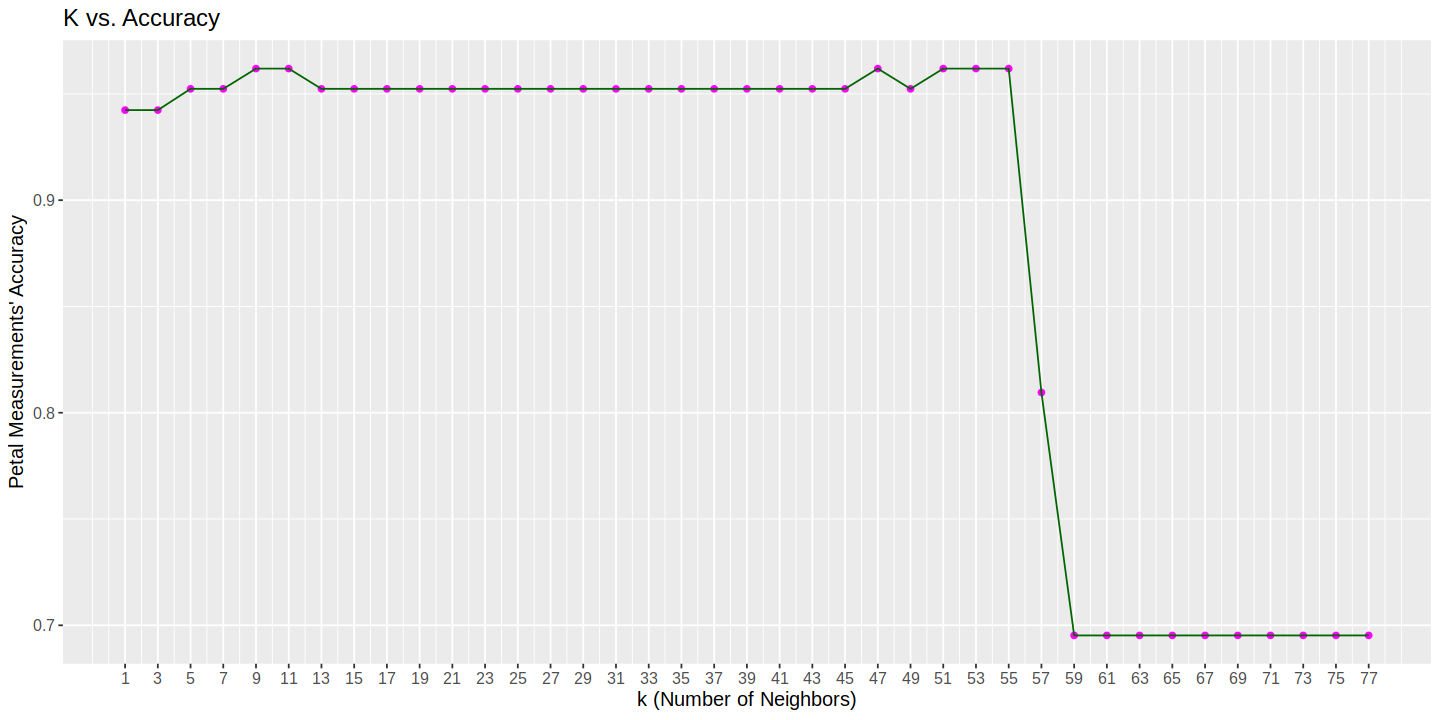

In [37]:
options(repr.plot.height = 6, repr.plot.width = 12)
#1.6
k_vals_petal <- tibble(neighbors = seq(1,78, by=2))

#1.7
accurasies_petal <- petal_workflow |>
    tune_grid (resamples = petal_vfold, grid = k_vals_petal) |>
    collect_metrics() |>
    filter(.metric == "accuracy")
head(accurasies_petal)
#1.8
cross_val_plot_petal <- accurasies_petal |>
    ggplot(aes (x = neighbors, y = mean,)) +
    geom_point(color = "#FF00FF") +
    geom_line(color = "#006400") +
    labs (x = "k (Number of Neighbors)",
          y = "Petal Measurements' Accuracy",
         title = "K vs. Accuracy") +
    theme(text = element_text(size = 12))+
    scale_x_continuous(breaks = seq(1, 78, by = 2)) # adjusting the x-axis
cross_val_plot_petal

##### 1.9 As shown in the `K`Vs.`accuracy` plot, the best $K$ is $K$=55

### 2. Now that we have obtained our best `K`, we will perform `knn` on our training data with this value of `k`
##### 2.1. Create a new `knn` `model`, using the appropriate engine and mode and set `neighbors = 55` as we obtained in the cross-validation.
##### 2.2. Fit the `recipe` we made previously called`petal_recipe`and new `model` into the `workflow`.
##### 2.3. Use the function `predict` to apply the prediction on our testing data `iris_test_petal`.
##### 2.4. Finally we report the accuracy of this prediction and will store this number to compare to accuracy of our `Sepal` model.

In [9]:
#2.1 
petal_final_spec <- nearest_neighbor (weight_func = "rectangular", neighbors = 55)|>
    set_engine("kknn") |>
    set_mode("classification")

#2.2
petal_final_workflow <- workflow() |>
    add_recipe (petal_recipe)|>
    add_model (petal_final_spec)|>
    fit(data= iris_train_petal)
petal_final_workflow

2.3
petal_prediction <- predict(petal_final_workflow, iris_test_petal)|>
    bind_cols (iris_test_petal)
head(petal_prediction)

2.4
petal_accuracy <- petal_prediction |>
  metrics(truth = class, estimate = .pred_class) |>
  filter(.metric == "accuracy")
head(petal_accuracy)

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
0 Recipe Steps

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = min_rows(55,     data, 5), kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.04807692
Best kernel: rectangular
Best k: 55

[1] 2.3

.pred_class,class,petal_width,petal_length
<fct>,<fct>,<dbl>,<dbl>
virginica,virginica,2.5,5.7
versicolor,versicolor,1.1,3.9
virginica,virginica,2.3,5.1
versicolor,versicolor,1.2,3.9
virginica,virginica,2.1,5.5
virginica,virginica,1.9,5.1


[1] 2.4

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,multiclass,0.9777778


#### The Petal KNN Classification model's Accuracy = 0.9777778

### Sepal KNN Classification:
#### Predictors: 
    * Sepal Width
    * Sepal Length

### 1. First we perform cross-validation to obtain the best K
##### 1.1. Select the desired columns from `iris_train` and `iris_test`

In [10]:
#1.1
iris_train_sepal  <- iris_train |>
    select (class, sepal_width, sepal_length)
nrow(iris_train_sepal)

iris_test_sepal  <- iris_test |>
    select (class, sepal_width, sepal_length)
nrow(iris_test_sepal)

head (iris_train_sepal)
head (iris_test_sepal)

[1] 104

[1] 45

class,sepal_width,sepal_length
<fct>,<dbl>,<dbl>
setosa,3.9,5.4
virginica,2.8,6.4
virginica,3.1,6.7
setosa,4.1,5.2
versicolor,3.0,5.4
virginica,2.6,7.7


class,sepal_width,sepal_length
<fct>,<dbl>,<dbl>
virginica,3.3,6.7
versicolor,2.5,5.6
virginica,3.1,6.9
versicolor,2.7,5.8
virginica,3.0,6.8
virginica,2.7,5.8


##### 1.2. Split the `iris_train_sepal` for cross-validation through `vfold_cv`.
##### 1.3. Create the `recipe`, include the correct `predictors` and `pre-process` the data.
##### 1.4. Create the `knn` `model`, using the appropriate engine and mode and set `neighbors = tune()`.
##### 1.5. Fit the `recipe` and `model` into the `workflow`.

In [11]:
#1.2
sepal_vfold <- vfold_cv(iris_train_sepal, strata= class, v = 5)

#1.3
sepal_recipe <- recipe (class ~ . , data= iris_train_sepal)
sepal_recipe

#1.4
sepal_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
    set_engine ("kknn") |>
    set_mode ("classification")
sepal_spec

#1.5
sepal_workflow <- workflow() |>
    add_recipe (sepal_recipe)|>
    add_model (sepal_spec)
sepal_workflow

Recipe

Inputs:

      role #variables
   outcome          1
 predictor          2

K-Nearest Neighbor Model Specification (classification)

Main Arguments:
  neighbors = tune()
  weight_func = rectangular

Computational engine: kknn 


══ Workflow ════════════════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
0 Recipe Steps

── Model ───────────────────────────────────────────────────────────────────────
K-Nearest Neighbor Model Specification (classification)

Main Arguments:
  neighbors = tune()
  weight_func = rectangular

Computational engine: kknn 


##### 1.6. Made a `tibble` called `k_vals` to determine the range and intervals of $K$s we want to perform the cross-validation on.
##### 1.7. Used the `tune_grid` function on our train/validation splits to estimate the classifier accuracy for a range of K values, collected and filtered the `accuracy` to obtain the `accuracies` of our $K$s.
##### 1.8. Plotted `accuracy` vs. `K` to visualize what would be the best $K$ with the highest accuracy estimate that doesn’t change much if you change K to a nearby value.

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,multiclass,0.6638095,5,0.02490799,Preprocessor1_Model01
3,accuracy,multiclass,0.7504762,5,0.02683620,Preprocessor1_Model02
5,accuracy,multiclass,0.7700000,5,0.03063574,Preprocessor1_Model03
7,accuracy,multiclass,0.7309524,5,0.03831780,Preprocessor1_Model04
9,accuracy,multiclass,0.7504762,5,0.02683620,Preprocessor1_Model05
11,accuracy,multiclass,0.7314286,5,0.02281743,Preprocessor1_Model06


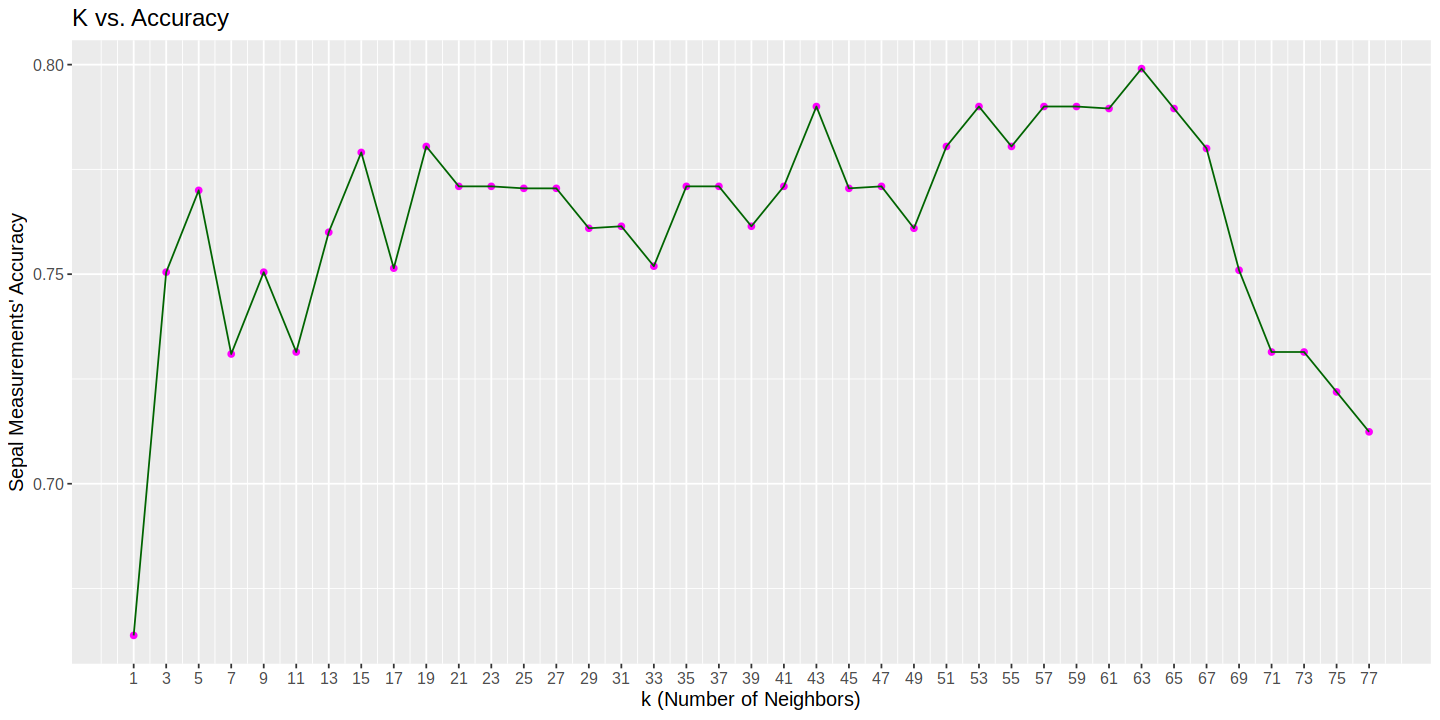

In [46]:
options(repr.plot.height = 6, repr.plot.width = 12)
#1.6
k_vals_sepal <- tibble(neighbors = seq(1,78, by=2))

#1.7
accurasies_sepal <- sepal_workflow |>
    tune_grid (resamples = sepal_vfold, grid = k_vals_sepal) |>
    collect_metrics() |>
    filter(.metric == "accuracy")
head(accurasies_sepal)
#1.8
cross_val_plot_sepal <- accurasies_sepal |>
    ggplot(aes (x = neighbors, y = mean)) +
    geom_point(color = "#FF00FF") +
    geom_line(color = "#006400") +
    labs (x = "k (Number of Neighbors)",
          y = "Sepal Measurements' Accuracy",
         title = "K vs. Accuracy") +
    theme(text = element_text(size = 12))+
    scale_x_continuous(breaks = seq(1, 78, by = 2)) # adjusting the x-axis
cross_val_plot_sepal

##### 1.9 As shown in the `K`Vs.`accuracy` plot, the best $K$ is $K$=35

### 2. Now that we have obtained our best `K`, we will perform `knn` on our training data with this value of `k`
##### 2.1. Create a new `knn` `model`, using the appropriate engine and mode and set `neighbors = 35` as we obtained in the cross-validation.
##### 2.2. Fit the `recipe` we made previously called`sepal_recipe`and new `model` into the `workflow`.
##### 2.3. Use the function `predict` to apply the prediction on our testing data `iris_test_sepal`.
##### 2.4. Finally we report the accuracy of this prediction and will store this number to compare to accuracy of our `Petal` model.

In [13]:
#2.1 
sepal_final_spec <- nearest_neighbor (weight_func = "rectangular", neighbors = 63)|>
    set_engine("kknn") |>
    set_mode("classification")

#2.2
sepal_final_workflow <- workflow() |>
    add_recipe (sepal_recipe)|>
    add_model (sepal_final_spec)|>
    fit(data= iris_train_sepal)
sepal_final_workflow

2.3
sepal_prediction <- predict(sepal_final_workflow, iris_test_sepal)|>
    bind_cols (iris_test_sepal)
head(sepal_prediction)

2.4
sepal_accuracy <- sepal_prediction |>
  metrics(truth = class, estimate = .pred_class) |>
  filter(.metric == "accuracy")
head(sepal_accuracy)

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
0 Recipe Steps

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = min_rows(63,     data, 5), kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.2403846
Best kernel: rectangular
Best k: 63

[1] 2.3

.pred_class,class,sepal_width,sepal_length
<fct>,<fct>,<dbl>,<dbl>
virginica,virginica,3.3,6.7
versicolor,versicolor,2.5,5.6
virginica,virginica,3.1,6.9
versicolor,versicolor,2.7,5.8
virginica,virginica,3.0,6.8
versicolor,virginica,2.7,5.8


[1] 2.4

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,multiclass,0.8222222


#### The Sepal KNN Classification model's Accuracy = 0.8222222

### Determine the best predictor set
#### Now that we are done doing the classification of both prediction factors of Petal and Sepal, we will compare their accuracies:

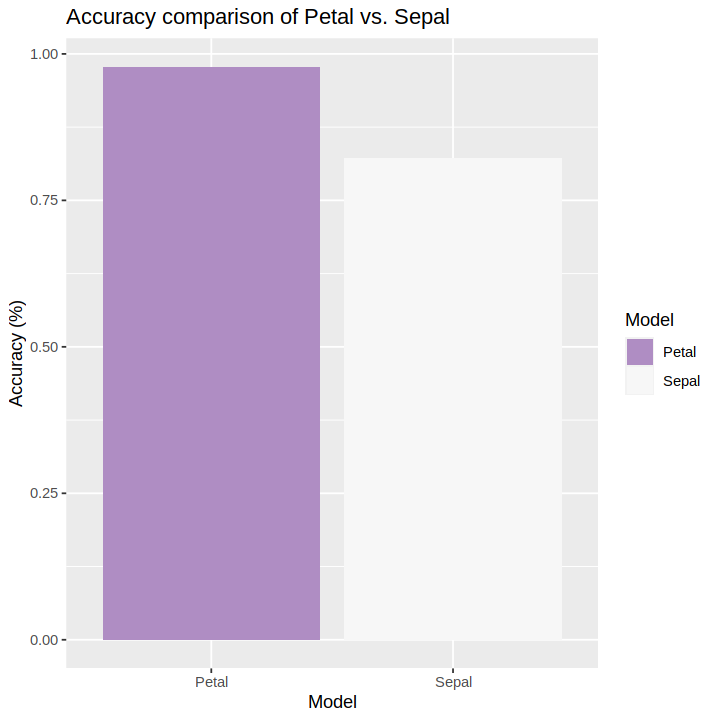

In [45]:
options(repr.plot.height = 6, repr.plot.width = 6)
iris_colors <- c("Sepal" = "#006400", "Petal" = "#4B0082" )
#select only the accuracies column
petal_accuracy <- petal_accuracy |>
select (.estimate)
sepal_accuracy <- sepal_accuracy |>
select (.estimate)

#Create a tibble of accuracies of 3 models
accuracies_comparison <- tibble (model = c("Petal", "Sepal"),
                                 accuracy = c(petal_accuracy, sepal_accuracy))

#visualize the comparison of 3 model's accuracies
model_comparison_plot <- accuracies_comparison |>
ggplot (aes(x = model, y = as.numeric(accuracy), fill = model)) +
geom_bar (stat = "identity") +
labs (x = "Model", y = "Accuracy (%)", fill = "Model") +
ggtitle("Accuracy comparison of Petal vs. Sepal")+
scale_fill_brewer (palette = "PRGn" )

model_comparison_plot

The bar graph of comparison of the 2 predicting groups shows that although there is a difference of 0.1333334 between the accurasies, the diffrenec is si small that it can be ignored when predicting the type of the iris flower. However, the petal model is slightly more accurate and looking at length and width of the petal could be more beneficial for predicting the type of iris flower from the three types of `Virginica`, `Setosa`, and `Versicolor`.

### Discussion: .....

### Refrrences: ....
* https://archive.ics.uci.edu/dataset/53/iris